In [4]:
import os

os.chdir('..')

In [1]:
import pickle

import seaborn as sns
import torch
from matplotlib import pyplot as plt
import numpy as np
import data_processing.preprocessing as preprocessing
from config import left_cut, right_cut

sns.set()

%load_ext autoreload
%autoreload 2

### SETUP

In [5]:
# Now we create the dataset by plugging the sampled coefficients
x_waves = preprocessing.read_wavelengths("dataset/HSI_Human_Brain_Database_IEEE_Access/{}/raw.hdr".format('004-02'))
molecules, x = preprocessing.read_molecules(left_cut, right_cut, x_waves)
y_water, y_fat, y_hbo2_f, y_hb_f, y_coxa, y_creda = molecules

with open('dataset/synthetic/spectra.pkl', 'rb') as f:
    synth_spect_dataset = pickle.load(f)
with open('dataset/synthetic/params.pkl', 'rb') as f:
    synth_spect_params = pickle.load(f)

In [6]:
synth_spect_dataset.shape

torch.Size([10000, 548])

In [7]:
path = "dataset" + "/HSI_Human_Brain_Database_IEEE_Access/"
patient_dirs = os.listdir(path)
patient_dirs = [directory for directory in patient_dirs if os.path.isdir(os.path.join(path, directory))]

images = []
for idx, dir in enumerate(patient_dirs):
    hdr_path = "{}/raw.pt".format(path + dir)
    img = torch.load(hdr_path)
    gt_path = "{}/gtMap.pt".format(path + dir)
    gt = torch.load(gt_path).int()

    mask = ((gt != 0) & (gt != 4))
    img = img[mask.expand_as(img)].reshape(826, -1)
    gt = gt[mask].reshape(1, -1)
    x_waves = np.array(preprocessing.read_wavelengths(path + "{}/raw.hdr".format('004-02')))
    cut_mask = (x_waves >= left_cut) & (x_waves <= right_cut)
    img = img[cut_mask]
    img = torch.permute(img, (1, 0))
    images.append(img)
    break

In [8]:
test = img[0]
test = img[0] / torch.max(test)

In [8]:
from sklearn.metrics import mean_squared_error

best = None
best_idx = None
mse_min = 100000000
mse_list = []
for idx, spect in enumerate(synth_spect_dataset):
    spect = spect / torch.max(spect)
    mse_new = mean_squared_error(test, spect)
    mse_list.append(mse_new)
    if mse_new < mse_min:
        best = spect
        best_idx = idx
        mse_min = mse_new

print(synth_spect_params[best_idx])

tensor([0.6140, 0.3560, 0.1948, 0.0016, 0.0172, 0.0010])


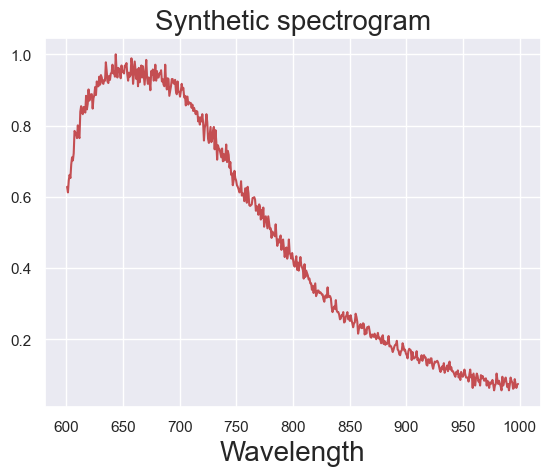

In [15]:
plt.plot(x, test, color='r')
plt.xlabel("Wavelength", fontsize=20)
plt.title("Synthetic spectrogram", fontsize=20)
plt.show()

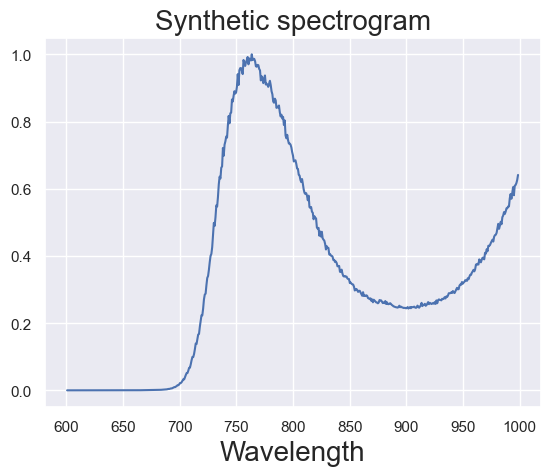

In [23]:
plt.plot(x, best, color='b')
plt.xlabel("Wavelength", fontsize=20)
plt.title("Synthetic spectrogram", fontsize=20)
plt.show()

### GRID SEARCH

In [24]:
from tqdm import tqdm

tuples_list = []
step = 2
for i in tqdm(range(1, 94, step)):
    for j in range(1, 94 - i, step):
        for k in range(1, 94 - i - j, step):
            for l in range(1, 94 - i - j - k, step):
                for m in range(1, 94 - i - j - k - l, step):
                    n = 100 - i - j - k - l - m
                    tuples_list.append((i, j, k, l, m, n))
len(tuples_list)

100%|██████████| 47/47 [00:00<00:00, 112.88it/s]


1906884

In [25]:
tuples_list = np.array(tuples_list) / 100

In [20]:
print(tuples_list[0])

[0.01 0.01 0.01 0.01 0.01 0.95]


In [11]:
test.shape

torch.Size([548])

In [26]:
from data_processing.generate_dataset import generate_and_compare_custom

best, best_params, mse_min, real_spectrogram = generate_and_compare_custom(test, tuples_list)

 67%|██████▋   | 1278952/1906884 [3:44:26<1:15:11, 139.20it/s]  

In [22]:
mse_min

0.28053440975143007